#Описание задачи
Задача - создать модель машинного обучения для мониторинга безопасности одиноких пожилых людей на основе данных от датчиков газа, температуры и инфракрасных датчиков движения. Модель должна способна определять аномалии и необычное поведение, которые могут потребовать вмешательства или помощи.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
import pickle

# Загрузка данных

In [ ]:
data = pd.read_csv("/content/data_ref_until_2020-02-13.csv")

In [ ]:
data_gas = pd.read_csv("/content/database_gas.csv")

In [ ]:
data_pos = pd.read_csv("/content/database_pos.csv")

In [ ]:
def change_datetime(data, col):
  data['date'] = data[col].str[:10]
  data['time'] = data[col].str[10:19]
  data['time_H_M'] = data['time'].str[:6]
  data['time_H'] = data['time'].str[:3]

  return data

*   temperature - температура
*   humidity - влажность
*   CO2CosIRValue -
*   CO2MG811Value - углекислый газ с датчика MG811
*   MOX - оксиды металлов
*   COValue - оксид углерода





In [ ]:
data.describe()

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
count,75511.000000,75511.000000,75511.000000,75511.000000,75511.00000,75511.000000,75511.000000,75511.000000,75511.000000
mean,20.025767,56.690943,70.176226,510.003523,538.73139,724.035849,675.748619,625.210473,114.237290
std,1.404978,2.416317,22.969229,9.233296,21.36482,19.940654,22.754632,27.964882,21.903941
min,14.820000,46.270000,37.000000,420.000000,339.00000,634.000000,575.000000,473.000000,82.000000
25%,19.940000,55.360000,53.000000,502.000000,530.00000,710.000000,663.000000,611.000000,101.000000
50%,20.230000,57.030000,69.000000,509.000000,537.00000,722.000000,676.000000,626.000000,109.000000
75%,20.640000,58.310000,74.000000,518.000000,545.00000,742.000000,690.000000,643.000000,120.000000
max,23.470000,69.260000,198.000000,526.000000,598.00000,791.000000,734.000000,690.000000,918.000000


In [ ]:
data.head(5)

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0


#Посмотрим на данные по комнатам:

In [ ]:
data_pos.columns

Index(['datetime', 'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway'], dtype='object')

In [ ]:
data_pos[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']].head(10)

,Living room,Bedroom,Bathroom,Kitchen,Hallway
0,NaN,0.0,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN
4,NaN,0.0,NaN,NaN,NaN
5,NaN,1.0,NaN,NaN,NaN
6,NaN,0.0,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN
8,NaN,0.0,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN


Очень много пропусков в данных:

In [ ]:
data_pos.isna().sum()

datetime           0
Living room    19612
Bedroom        25317
Bathroom       22525
Kitchen        25957
Hallway        20530
dtype: int64

Заполним отсутствующие значения нулями:

In [ ]:
data_pos = data_pos.fillna(0)

Убедимся, что нет строк, где движение замечено сразу в двух комнатах:

In [ ]:
(data_pos['Living room'] + data_pos['Bedroom'] + data_pos['Bathroom'] + data_pos['Kitchen'] + data_pos['Hallway']).value_counts()

0.0    14275
1.0    14203
dtype: int64

Переведем даты в несколько удобных форматов:

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
data_pos = change_datetime(data_pos, 'datetime')

In [ ]:
data = change_datetime(data, 'timestamp')

In [ ]:
data_gas = change_datetime(data_gas, 'timestamp')

Построим график зависимости положения человека от времени в разрезе 24 часов:

In [ ]:
pos_to_hours = data_pos[['time_H', 'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']]
pos_to_hours_group = pos_to_hours.groupby(by=['time_H']).mean()
pos_to_hours_group.head(5)

,Living room,Bedroom,Bathroom,Kitchen,Hallway
time_H,,,,,
00,0.137500,0.192500,0.070000,0.022500,0.082500
01,0.133858,0.230971,0.049869,0.007874,0.073491
02,0.082437,0.301075,0.060932,0.000000,0.050179
03,0.081967,0.284153,0.065574,0.000000,0.065574
04,0.054313,0.329073,0.051118,0.000000,0.067093


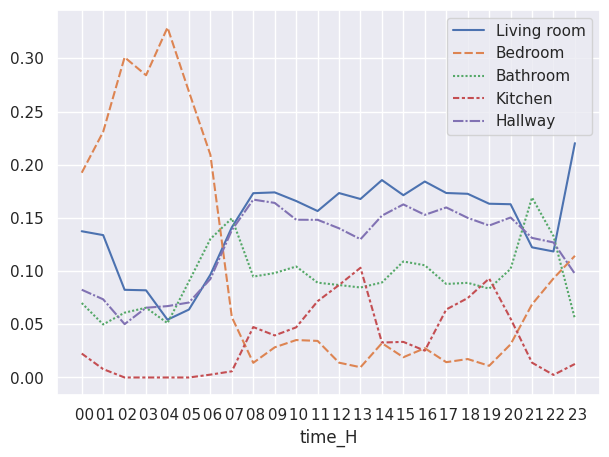

In [ ]:
sns.set(rc={'figure.figsize':(7., 5.)})
sns.lineplot(data=pos_to_hours_group);

Красота! Примерно в 21 час бабушки отправляются спать и просыпаются около 7 утра. В 7 и 21 посещают ванную комнату. На кухне они замечены в 8 (завтрак), 13 (обед) и 19 (ужин). В прихожей график равномерен в течение почти всего дня. Предположу, что прихожая обычно - проходная комната.

График рождественской активности:

In [ ]:
pos_to_date_hours = data_pos[data_pos['date'] == '2019-12-24'][['time_H', 'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']]
pos_to_date_hours_group = pos_to_date_hours.groupby(by=['time_H']).sum()

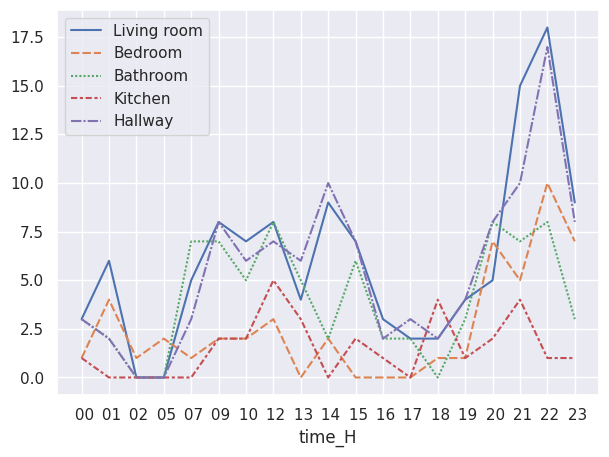

In [ ]:
sns.lineplot(data=pos_to_date_hours_group);

In [ ]:
# pos_to_date_hours.groupby(['date', 'time_H']).mean()

In [ ]:
# new_df = pos_to_date_hours.set_index(['date', 'time_H'])
# new_df = pd.DataFrame(new_df.idxmax(axis=1)).reset_index().rename(columns={0: 'room'})
# new_df.head(5)

In [ ]:
# sns.set(rc={'figure.figsize':(17.1, 10.1)})
# sns.barplot(data=new_df[new_df['date'] < '2020-01-01']) #, y='date', x = 'time_H', hue='room', ci=None)

Построим диаграмму, в которой выполним подсчет для каждой комнаты. Для наглядности расположим по убыванию:

In [ ]:
room_counts = pd.DataFrame(data_pos[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']].sum()).reset_index()
room_counts = room_counts.rename(columns={'index': 'room', 0: 'count'}).sort_values(['count'], ascending=False)
room_counts

,room,count
0,Living room,4428.0
4,Hallway,3969.0
2,Bathroom,2969.0
1,Bedroom,1578.0
3,Kitchen,1259.0


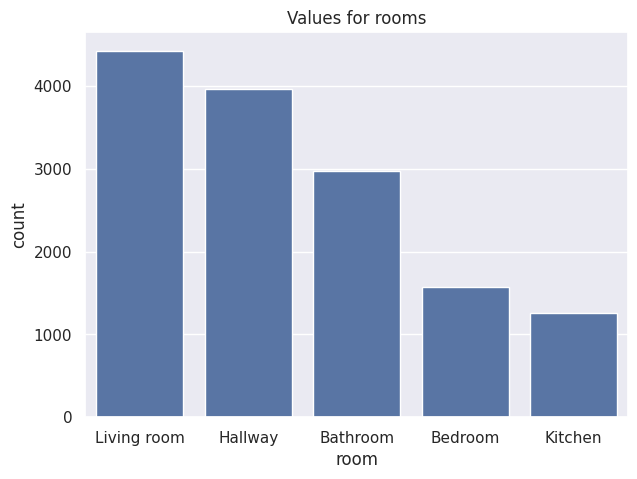

In [ ]:
sns.barplot(data=room_counts, x='room', y = 'count').set_title('Values for rooms')
sns.set(rc={'figure.figsize':(7., 5.)})

In [ ]:
# from matplotlib.pyplot import figure

# rooms = ['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']
# counts = data_pos[rooms].sum()

# plt.figure(figsize=(7,5))
# plt.bar(rooms, counts)

# plt.xlabel('Rooms')
# plt.ylabel('Values')
# plt.title('Values for rooms');

Чаще всего человек находился в гостиной и прихожей

#Посмотрим на данные с датчиков:

In [ ]:
data_gas.sample(5)

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,date,time,time_H_M,time_H
123268,2019-12-05 00:31:23.061737+01:00,22.52,55.23,121.0,551.0,451.0,700.0,658.0,585.0,128.0,2019-12-05,00:31:23,00:31,00
323719,2020-01-21 01:56:59.062006+01:00,20.03,48.62,96.0,503.0,508.0,711.0,674.0,608.0,101.0,2020-01-21,01:56:59,01:56,01
359861,2020-01-29 12:22:38.473167+01:00,19.88,56.64,70.0,503.0,536.0,717.0,676.0,624.0,113.0,2020-01-29,12:22:38,12:22,12
122622,2019-12-04 20:55:47.640505+01:00,23.80,52.94,116.0,550.0,435.0,688.0,648.0,572.0,130.0,2019-12-04,20:55:47,20:55,20
25399,2019-11-12 08:43:45.963122+01:00,18.16,41.69,69.0,621.0,523.0,783.0,749.0,683.0,104.0,2019-11-12,08:43:45,08:43,08


In [ ]:
data.sample(5)

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,date,time,time_H_M,time_H
73863,2020-02-13 02:49:17.282555+01:00,20.62,58.32,40.0,518.0,527.0,700.0,644.0,592.0,157.0,2020-02-13,02:49:17,02:49,02
48747,2020-02-07 07:17:15.370687+01:00,18.04,55.57,44.0,525.0,566.0,766.0,717.0,679.0,93.0,2020-02-07,07:17:15,07:17,07
65225,2020-02-11 02:50:01.857557+01:00,20.60,59.97,69.0,516.0,545.0,733.0,680.0,634.0,100.0,2020-02-11,02:50:01,02:50,02
19712,2020-01-29 15:06:58.009371+01:00,20.36,56.62,69.0,503.0,534.0,714.0,672.0,621.0,114.0,2020-01-29,15:06:58,15:06,15
64265,2020-02-10 21:30:00.752282+01:00,20.91,59.04,112.0,507.0,544.0,726.0,673.0,623.0,98.0,2020-02-10,21:30:00,21:30,21


Объединим данные с датчиков в одну таблицу:

In [ ]:
datasets = [data, data_gas]
data_gas_full = pd.concat(datasets)

data_gas_full = data_gas_full.rename(columns={'timestamp': 'datetime'})
data_gas_full.head()

,datetime,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,date,time,time_H_M,time_H
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0,2020-01-25,00:01:49,00:01,00
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0,2020-01-25,00:02:09,00:02,00
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0,2020-01-25,00:02:29,00:02,00
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0,2020-01-25,00:02:49,00:02,00
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0,2020-01-25,00:03:09,00:03,00


In [ ]:
data_gas_full.isna().sum()

datetime         0
temperature      0
humidity         0
CO2CosIRValue    0
CO2MG811Value    0
MOX1             0
MOX2             0
MOX3             0
MOX4             0
COValue          0
date             0
time             0
time_H_M         0
time_H           0
dtype: int64

Пропусков нет

In [ ]:
data_gas_full.columns

Index(['datetime', 'temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value',
       'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue', 'date', 'time', 'time_H_M',
       'time_H'],
      dtype='object')

In [ ]:
gas_to_date = data_gas_full[['date', 'temperature', 'humidity', 'CO2CosIRValue',
       'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']]
gas_to_date_group = gas_to_date.groupby(by=['date']).mean()
gas_to_date_group.head(5)

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
date,,,,,,,,,
2019-11-06,21.635875,51.059605,100.389138,607.285458,454.013465,741.990575,688.863106,610.695242,126.750449
2019-11-07,20.769958,52.328727,98.005324,605.896528,473.645602,738.406713,688.676620,620.367361,127.841204
2019-11-08,21.571727,49.650907,98.745833,604.884028,470.999306,733.619676,683.587500,609.768056,107.106481
2019-11-09,20.365002,50.260634,95.157176,607.495370,496.090741,746.185417,707.376157,634.255324,97.638889
2019-11-10,20.284259,48.218093,94.727778,607.988194,507.872222,751.921065,712.349306,640.589120,108.864352


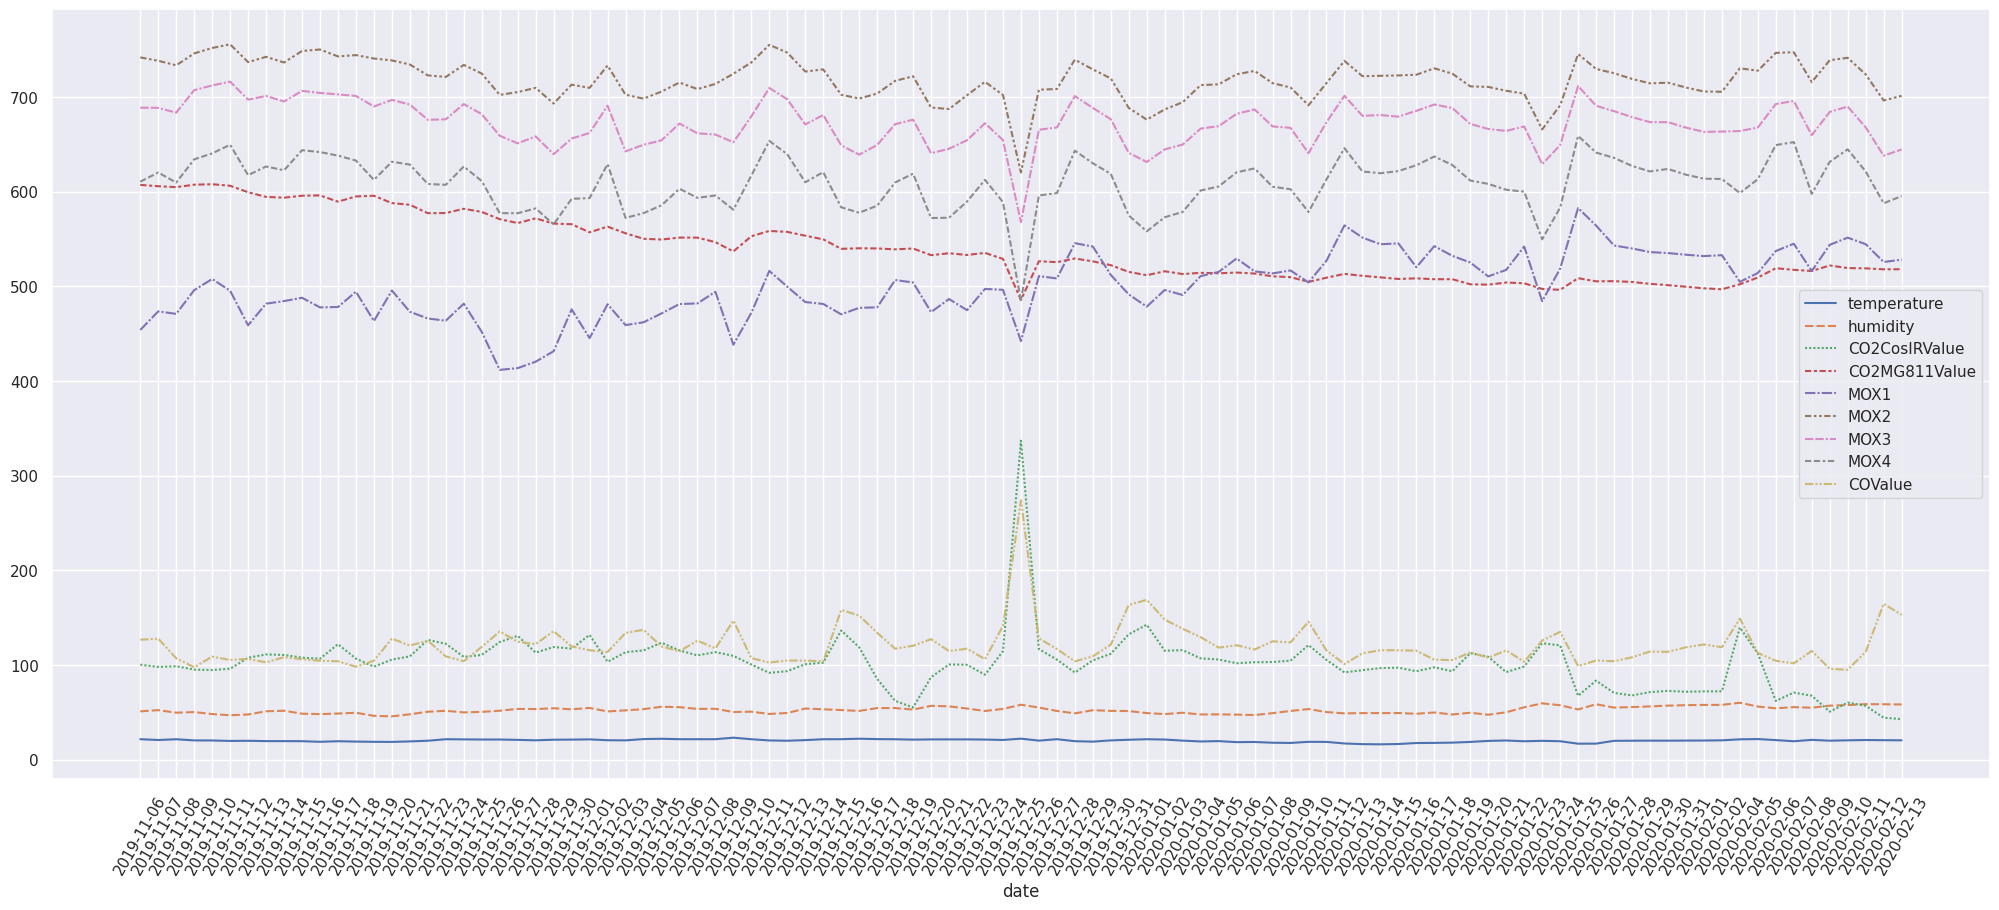

In [ ]:
plt.figure(figsize=(25, 10))
ax = sns.lineplot(data=gas_to_date_group)
plt.xticks(rotation=60);

Есть какой-то выброс 24.12.2019. Посмотрим на среднее значение датчиков в этот день:

In [ ]:
gas_to_date = data_gas_full[data_gas_full['date'] == '2019-12-24'][['time_H', 'temperature', 'humidity', 'CO2CosIRValue',
       'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']]
gas_to_date_group = gas_to_date.groupby(by=['time_H']).mean()

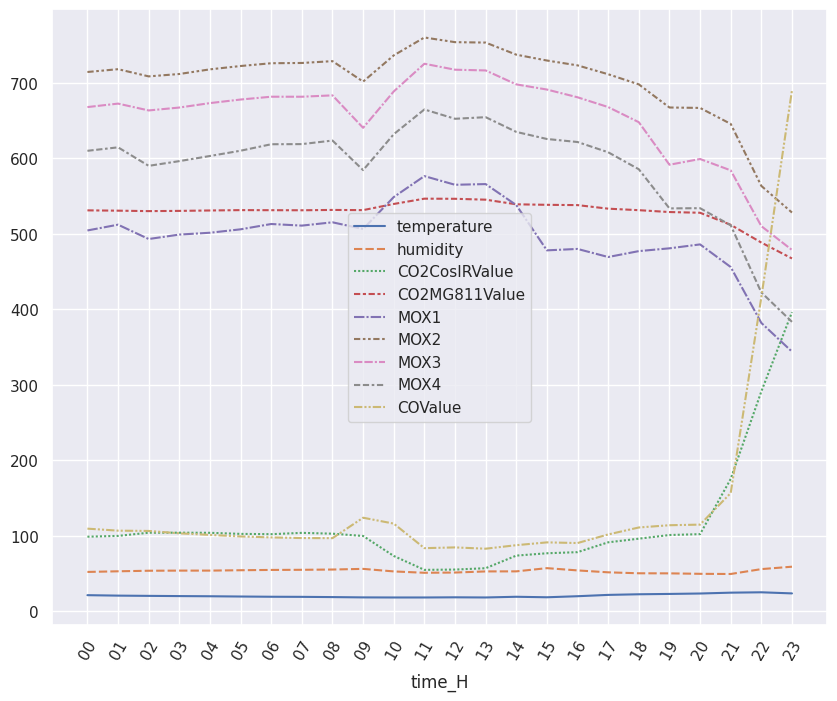

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=gas_to_date_group)
plt.xticks(rotation=60);

Возможно бабушки так сильно смеялись в рождественскую ночь, что показатели углекислого газа зашкаливали

Среднее значение датчиков по часам за все время:

In [ ]:
gas_to_hours = data_gas_full[['time_H', 'temperature', 'humidity', 'CO2CosIRValue',
       'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']]
gas_to_hours_group = gas_to_hours.groupby(by=['time_H']).mean()

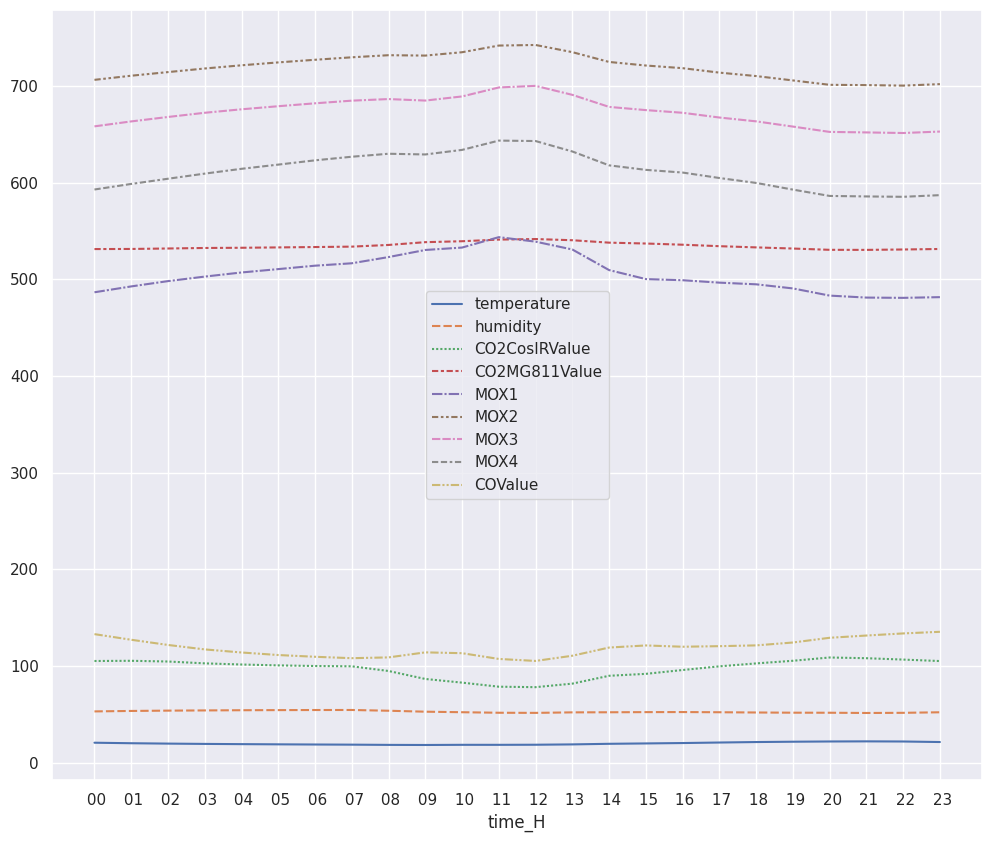

In [ ]:
sns.set(rc={'figure.figsize':(12., 10.)})
sns.lineplot(data=gas_to_hours_group);

Посмотрим на среднюю температуру в по дням. На прошлом графике из-за масштабов она почти не меняется:

In [ ]:
temperature_to_date = data_gas_full[['date', 'temperature']]
temperature_to_date_group = temperature_to_date.groupby(by=['date']).mean()

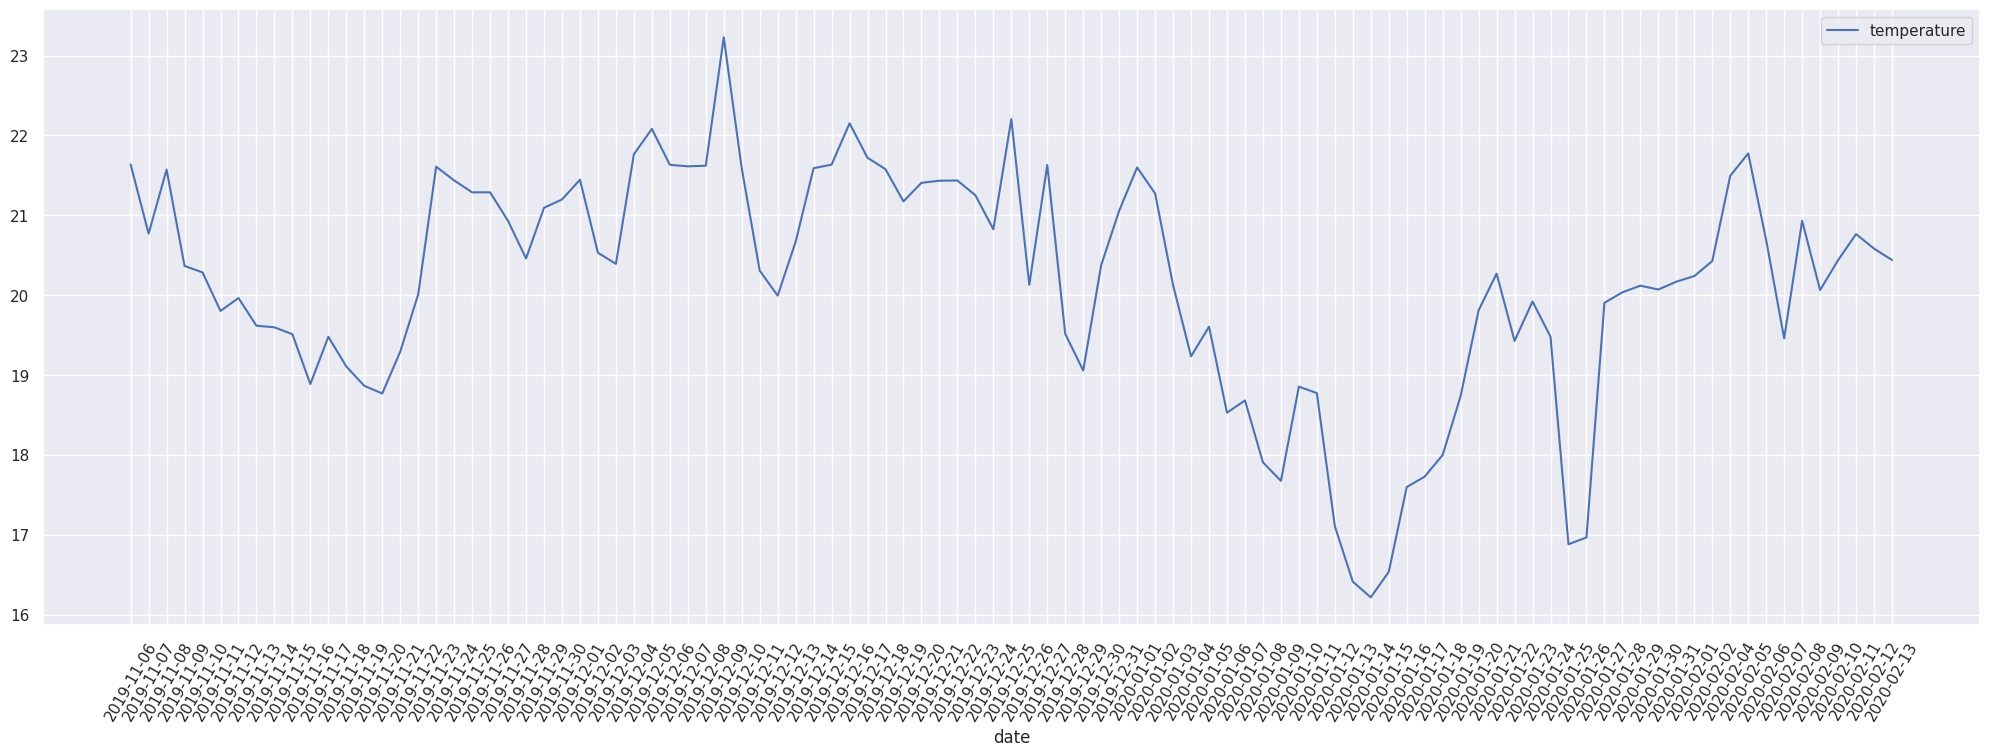

In [ ]:
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=temperature_to_date_group)
plt.xticks(rotation=60);

Построим матрицу корреляции:

In [ ]:
data_gas_full.columns

Index(['datetime', 'temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value',
       'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue', 'date', 'time', 'time_H_M',
       'time_H'],
      dtype='object')

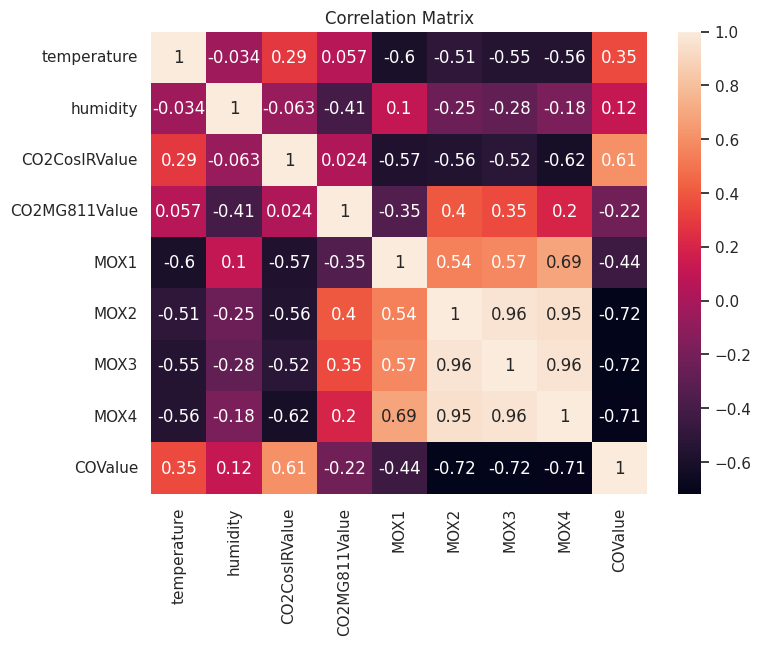

In [ ]:
cm = data_gas_full[['temperature', 'humidity', 'CO2CosIRValue',
       'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True)
plt.title('Correlation Matrix')

plt.show()

Есть сильно коррелирующие данные - показатели датчиков MOX2, MOX3 и MOX4

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
MOX = data_gas_full[['MOX2', 'MOX3', 'MOX4']]

pca = PCA(n_components=3, svd_solver='full').fit(MOX)
data_gas_full.drop(['MOX2', 'MOX3', 'MOX4'], inplace=True, axis=1)
data_gas_full['MOX_2_3_4'] = pca.transform(MOX)[:,0]

pca.explained_variance_ratio_[0]

0.9740030036005237

В датасете много пропущенных данных о местоположении. Заменим пустые строки на предыдущие, если между измерениями прошло не более двух часов:

In [ ]:
data_pos['room'] = data_pos['Living room'] + data_pos['Bedroom'] + data_pos['Bathroom'] + data_pos['Kitchen'] + data_pos['Hallway']
data_pos['room'].value_counts()

0.0    14275
1.0    14203
Name: room, dtype: int64

In [ ]:
for i in range(data_pos.shape[0]):
  if data_pos['room'].iloc[i] == 0:
    if int(data_pos['time_H'].iloc[i]) - int(data_pos['time_H'].iloc[i-1]) < 2:
      data_pos.iloc[i] = data_pos.iloc[i-1]

In [ ]:
data_pos = data_pos.iloc[1:]

In [ ]:
data_pos.head(5)

,datetime,Living room,Bedroom,Bathroom,Kitchen,Hallway,date,time,time_H_M,time_H,room
1,2019-11-01 03:19:57.417067700+00:00,0.0,1.0,0.0,0.0,0.0,2019-11-01,03:19:57,03:19,03,1.0
2,2019-11-01 03:19:57.417067700+00:00,0.0,1.0,0.0,0.0,0.0,2019-11-01,03:19:57,03:19,03,1.0
3,2019-11-01 05:11:08.874031+00:00,0.0,1.0,0.0,0.0,0.0,2019-11-01,05:11:08,05:11,05,1.0
4,2019-11-01 05:11:08.874031+00:00,0.0,1.0,0.0,0.0,0.0,2019-11-01,05:11:08,05:11,05,1.0
5,2019-11-01 05:14:15.993041400+00:00,0.0,1.0,0.0,0.0,0.0,2019-11-01,05:14:15,05:14,05,1.0


In [ ]:
data_pos['room'] = data_pos['Living room'] + data_pos['Bedroom'] + data_pos['Bathroom'] + data_pos['Kitchen'] + data_pos['Hallway']
data_pos['room'].value_counts()

1.0    28463
0.0       14
Name: room, dtype: int64

В datetime оставим только дату, часы и минуты, чтобы получить больше данных:

In [ ]:
data_gas_full['datetime'] = data_gas_full['date'] + data_gas_full['time_H_M']
data_pos['datetime'] = data_pos['date'] + data_pos['time_H_M']

In [ ]:
data_full = pd.merge(data_pos, data_gas_full, on=['datetime'])
data_full = data_full[['date_x', 'time_H_x', 'time_H_M_x', 'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway', 'temperature', 'humidity',
       'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'COValue', 'MOX_2_3_4']]

Теперь мы можем видеть все измерение в одном месте:

In [ ]:
data_full[(data_full.date_x.str.startswith('2020-01-18'))].head(5)

,date_x,time_H_x,time_H_M_x,Living room,Bedroom,Bathroom,Kitchen,Hallway,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,COValue,MOX_2_3_4
65560,2020-01-18,03,03:22,0.0,1.0,0.0,0.0,0.0,18.14,49.45,102.0,505.0,539.0,97.0,-33.043382
65561,2020-01-18,03,03:22,0.0,1.0,0.0,0.0,0.0,18.14,49.45,102.0,505.0,539.0,98.0,-33.043382
65562,2020-01-18,03,03:22,0.0,1.0,0.0,0.0,0.0,18.14,49.45,102.0,505.0,539.0,98.0,-33.043382
65563,2020-01-18,03,03:22,0.0,1.0,0.0,0.0,0.0,18.14,49.45,102.0,505.0,539.0,97.0,-33.043382
65564,2020-01-18,03,03:22,0.0,1.0,0.0,0.0,0.0,18.14,49.45,102.0,505.0,539.0,98.0,-33.043382


Построим график. В целом он ничем не отличается от графика до дополнения, только время обеда немного сместилось:

In [ ]:
pos_to_date_hours = data_full[['time_H_x', 'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']]
pos_to_date_hours_group = pos_to_date_hours.groupby(by=['time_H_x']).mean()

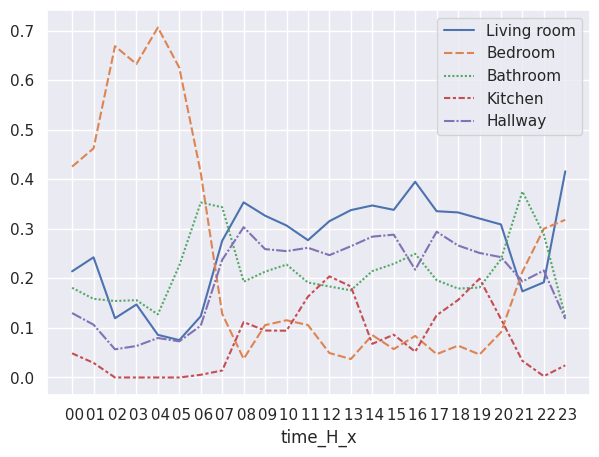

In [ ]:
sns.set(rc={'figure.figsize':(7., 5.)})
sns.lineplot(data=pos_to_date_hours_group);

График времени сна:

In [ ]:
sleep_to_date_hours = data_full[data_full['date_x'] == '2020-01-05'][['time_H_x', 'Bedroom']]

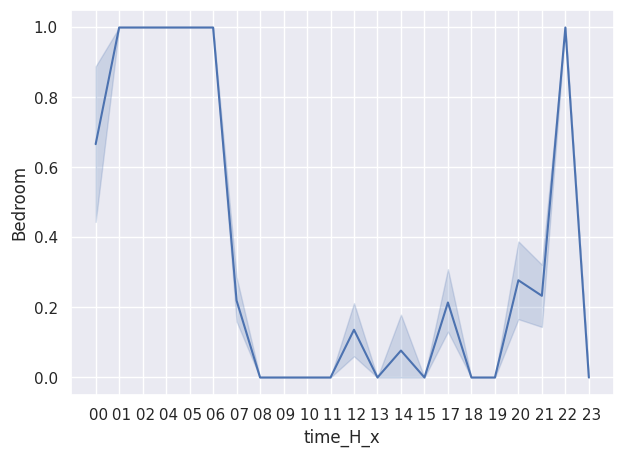

In [ ]:
sns.set(rc={'figure.figsize':(7., 5.)})
sns.lineplot(data=sleep_to_date_hours, x = 'time_H_x', y = 'Bedroom');

Объединим комнаты в один столбец:

In [ ]:
new_df = data_full.set_index(['date_x', 'time_H_x', 'time_H_M_x', 'temperature', 'humidity',
       'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'COValue', 'MOX_2_3_4'])
new_df = pd.DataFrame(new_df.idxmax(axis=1)).reset_index().rename(columns={0: 'room'})

In [ ]:
new_df[new_df['date_x'] == '2019-11-06'].head()

,date_x,time_H_x,time_H_M_x,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,COValue,MOX_2_3_4,room
0,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,Living room
1,2019-11-06,12,12:18,19.44,48.00,77.0,621.0,572.0,94.0,-127.491866,Living room
2,2019-11-06,12,12:18,19.39,48.00,76.0,622.0,572.0,94.0,-128.537175,Living room
3,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,Hallway
4,2019-11-06,12,12:18,19.44,48.00,77.0,621.0,572.0,94.0,-127.491866,Hallway


In [ ]:
new_df['room'].value_counts()

Living room    25764
Hallway        20896
Bathroom       20400
Bedroom        12563
Kitchen         8647
Name: room, dtype: int64

Хочу добавить столбцы "длительность текущего посещения данной комнаты" и "номер посещения за день"

In [ ]:
new_df['time_in_room'] = 0
new_df['room_visit_count'] = 0

In [ ]:
%%capture

import time
from datetime import datetime

time_rooms_all_days = pd.DataFrame()

days = new_df['date_x'].unique()

for day in days:

  rooms_visit_counts = {'Living room': 0, 'Bedroom': 0, 'Bathroom': 0, 'Kitchen': 0, 'Hallway': 0}

  day_df = new_df[new_df['date_x'] == day]

  start_time = day_df.iloc[0]['time_H_M_x'] # 00:01
  start_room = day_df.iloc[0]['room'] # Living room

  rooms_visit_counts[start_room] += 1

  for row in range(day_df.shape[0]):
    if row == 0:
      day_df['time_in_room'].iloc[row] = 0
      day_df['room_visit_count'].iloc[row] = rooms_visit_counts[day_df.iloc[0]['room']]

    else:

      if day_df['room'].iloc[row] == start_room:
        day_df['room_visit_count'].iloc[row] = rooms_visit_counts[day_df.iloc[row]['room']]

        start_time_dt = datetime.strptime(day_df['time_H_M_x'].iloc[row - 1].replace(' ', ''), '%H:%M')
        last_time = datetime.strptime(day_df['time_H_M_x'].iloc[row].replace(' ', ''), '%H:%M') # 00:21
        time_difference = (last_time - start_time_dt).total_seconds()

        day_df['time_in_room'].iloc[row] = time_difference + day_df['time_in_room'].iloc[row - 1]

      else:
        rooms_visit_counts[day_df['room'].iloc[row]] += 1
        day_df['room_visit_count'].iloc[row] = rooms_visit_counts[day_df.iloc[row]['room']]
        day_df['time_in_room'].iloc[row] = 0

        start_room = day_df['room'].iloc[row]

  time_rooms_all_days = pd.concat([time_rooms_all_days, day_df], ignore_index=True)

Обозначим ночной и утренний сон, исходя из средних показателей. Переведем длительность посещения в datetime:

In [ ]:
%%capture

import datetime
time_rooms_all_days['is_night'] = 0
time_rooms_all_days['sleep'] = 0

for row in range(time_rooms_all_days.shape[0]):
  # time_rooms_all_days['time_in_room'].iloc[row] = str(datetime.timedelta(seconds=int(time_rooms_all_days['time_in_room'].iloc[row])))

  if (int(time_rooms_all_days['time_H_x'].iloc[row]) < 7):
    time_rooms_all_days['is_night'].iloc[row] = 1
    time_rooms_all_days['sleep'].iloc[row] = 'M'

  if (int(time_rooms_all_days['time_H_x'].iloc[row]) > 22):
    time_rooms_all_days['is_night'].iloc[row] = 1
    time_rooms_all_days['sleep'].iloc[row] = 'N'

In [ ]:
time_rooms_all_days.sample(5)

,date_x,time_H_x,time_H_M_x,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,COValue,MOX_2_3_4,room,time_in_room,room_visit_count,is_night,sleep
77774,2020-02-05,11,11:29,22.37,55.42,133.0,508.0,514.0,125.0,25.202680,Hallway,0,34,0,0
12152,2019-11-20,15,15:04,17.82,46.88,97.0,592.0,459.0,127.0,-31.611697,Living room,60,22,0,0
35012,2019-12-16,09,09:35,19.10,54.27,110.0,545.0,508.0,132.0,-0.043037,Hallway,0,7,0,0
77238,2020-02-05,09,09:18,21.80,55.14,118.0,512.0,524.0,110.0,19.223628,Bathroom,0,15,0,0
84045,2020-02-08,13,13:01,21.34,54.70,90.0,509.0,510.0,105.0,100.155912,Kitchen,0,13,0,0


In [ ]:
time_rooms_all_days[time_rooms_all_days['date_x'] == '2020-01-20']

,date_x,time_H_x,time_H_M_x,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,COValue,MOX_2_3_4,room,time_in_room,room_visit_count,is_night,sleep
67102,2020-01-20,01,01:03,19.80,48.38,112.0,501.0,493.0,116.0,10.356405,Bedroom,0,1,1,M
67103,2020-01-20,01,01:03,19.78,48.38,111.0,501.0,493.0,116.0,9.685324,Bedroom,0,1,1,M
67104,2020-01-20,01,01:03,19.76,48.38,112.0,501.0,493.0,116.0,9.685324,Bedroom,0,1,1,M
67105,2020-01-20,01,01:03,19.80,48.38,112.0,501.0,493.0,116.0,10.356405,Bedroom,0,1,1,M
67106,2020-01-20,01,01:03,19.78,48.38,111.0,501.0,493.0,116.0,9.685324,Bedroom,0,1,1,M
67107,2020-01-20,01,01:03,19.76,48.38,112.0,501.0,493.0,116.0,9.685324,Bedroom,0,1,1,M
67108,2020-01-20,02,02:30,19.06,47.21,105.0,503.0,518.0,105.0,-19.605066,Bedroom,5220,1,1,M
67109,2020-01-20,02,02:30,19.06,47.38,105.0,503.0,518.0,105.0,-19.605066,Bedroom,5220,1,1,M
67110,2020-01-20,02,02:30,19.06,47.41,105.0,503.0,518.0,105.0,-19.605066,Bedroom,5220,1,1,M
67111,2020-01-20,02,02:30,19.06,47.21,105.0,503.0,518.0,105.0,-19.605066,Bedroom,5220,1,1,M


In [ ]:
time_rooms_all_days['sleep'].value_counts()

0    78578
M     8957
N      735
Name: sleep, dtype: int64

In [ ]:
time_rooms_all_days_group = time_rooms_all_days.groupby(['date_x', 'room', 'room_visit_count', 'sleep']).agg({'time_in_room': np.max, 'is_night': np.max})

In [ ]:
time_rooms_all_days_group.head(10)

time_in_room  is_night
date_x     room     room_visit_count sleep                        
2019-11-06 Bathroom 1                0                60         0
                    2                0               120         0
                    3                0                60         0
                    4                0                60         0
                    5                0                 0         0
                    6                0                60         0
                    7                0                60         0
                    8                0               660         0
                    9                0                 0         0
           Bedroom  1                0                 0         0

Аномалией среди посещений можно считать: долгое время, проведенное в ванной комнате; много пробуждений среди ночи; отсутствие достаточного количества посещений кухни в течение дня

Введем два понимания аномалий: аномалия дня и аномалия текущего момента:

In [ ]:
time_rooms_all_days['anomaly_moment'] = 0
time_rooms_all_days['anomaly_day'] = 0

In [ ]:
for i in range(len(days)):
  prev_date = days[i]

  if prev_date != days[-1]:

    next_day = days[i + 1]

    df_all = time_rooms_all_days[(((time_rooms_all_days['date_x'] == prev_date) & (time_rooms_all_days['sleep'] == 'N')) |
      ((time_rooms_all_days['date_x'] == next_day) & (time_rooms_all_days['sleep'] == 'M'))) & ((time_rooms_all_days['is_night'] == 1) & (time_rooms_all_days['room'] == 'Bathroom'))]

    bathroom_count = len(df_all[df_all['sleep'] =='N']['room_visit_count'].unique())

    time_rooms_all_days.loc[(time_rooms_all_days['date_x'] == next_day) & (time_rooms_all_days['is_night'] == 1) & (time_rooms_all_days['room'] == 'Bathroom') & (time_rooms_all_days['sleep'] == 'M') &
                        (time_rooms_all_days['room_visit_count'] >= (3 - bathroom_count)), 'anomaly_moment'] = 1

In [ ]:
for day in days:

# если сейчас человек посещал кухню меньше 2 раз
  if (len(time_rooms_all_days[(time_rooms_all_days['room'] == 'Kitchen') & (time_rooms_all_days['date_x'] == day) & (time_rooms_all_days['time_in_room'] != 0)]['room_visit_count'].unique()) < 2):
    time_rooms_all_days.loc[time_rooms_all_days['date_x'] == day, 'anomaly_day'] = 1

# если сейчас ночь, человек не спит и находится в другой комнате больше получаса
time_rooms_all_days.loc[(time_rooms_all_days['is_night'] == 1) & (time_rooms_all_days['room'] != 'Bedroom') & (time_rooms_all_days['time_in_room'] >= 20 * 60), 'anomaly_moment'] = 1

# если человек находится в ванной комнате больше 20 минут
time_rooms_all_days.loc[(time_rooms_all_days['room'] == 'Bathroom') & (time_rooms_all_days['time_in_room'] >= 20 * 60), 'anomaly_moment'] = 1

Получаем вот такое количество разметок аномалий:

In [ ]:
time_rooms_all_days[time_rooms_all_days['anomaly_moment'] == 1].shape[0], time_rooms_all_days[time_rooms_all_days['anomaly_day'] == 1].shape[0]

(608, 28138)

Рассмотри аномалии по данным с датчиков. За аномалию возьмем отклонение от среднего значения:

На территории Российской Федерации согласно ГОСТ Р ЕН 13779-2007, концентрация СО2 в помещении не должна превышать 400 ppm. Для того, чтобы качество воздуха считалось высоким. Средним качество воздуха в помещении считается если цифра не превышает 600 ppm. Возьмем 600 за максимум.

In [ ]:
time_rooms_all_days[['temperature', 'humidity',
       'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'COValue', 'MOX_2_3_4']].mean()

temperature       20.274300
humidity          52.184694
CO2CosIRValue    110.580469
CO2MG811Value    537.996307
MOX1             499.113640
COValue          127.015792
MOX_2_3_4          5.531970
dtype: float64

In [ ]:
time_rooms_all_days.loc[(abs(time_rooms_all_days['temperature'] - time_rooms_all_days['temperature'].mean()) > 6) |
          (abs(time_rooms_all_days['humidity'] - time_rooms_all_days['humidity'].mean()) > 12) |
          (abs(time_rooms_all_days['CO2CosIRValue'] - time_rooms_all_days['CO2CosIRValue'].mean()) > 150) |
          (abs(time_rooms_all_days['CO2MG811Value']) > 600) |
          (abs(time_rooms_all_days['MOX1'] - time_rooms_all_days['MOX1'].mean()) > 200) |
          (abs(time_rooms_all_days['COValue'] - time_rooms_all_days['COValue'].mean()) > 300) |
          (abs(time_rooms_all_days['MOX_2_3_4'] - time_rooms_all_days['MOX_2_3_4'].mean()) > 200), 'anomaly_moment'] = 1

In [ ]:
time_rooms_all_days.shape[0], time_rooms_all_days[time_rooms_all_days['anomaly_moment'] == 1].shape[0], time_rooms_all_days[time_rooms_all_days['anomaly_day'] == 1].shape[0]

(88270, 9799, 28138)

In [ ]:
room_dummy = pd.get_dummies(time_rooms_all_days['room'])

In [ ]:
time_rooms_all_days = pd.concat([time_rooms_all_days, room_dummy], axis=1)

In [ ]:
time_rooms_all_days.drop(['room'], inplace=True, axis=1)

In [ ]:
time_rooms_all_days.head(10)

,date_x,time_H_x,time_H_M_x,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,COValue,MOX_2_3_4,...,room_visit_count,is_night,sleep,anomaly_moment,anomaly_day,Bathroom,Bedroom,Hallway,Kitchen,Living room
0,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,...,1,0,0,1,0,0,0,0,0,1
1,2019-11-06,12,12:18,19.44,48.00,77.0,621.0,572.0,94.0,-127.491866,...,1,0,0,1,0,0,0,0,0,1
2,2019-11-06,12,12:18,19.39,48.00,76.0,622.0,572.0,94.0,-128.537175,...,1,0,0,1,0,0,0,0,0,1
3,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,...,1,0,0,1,0,0,0,1,0,0
4,2019-11-06,12,12:18,19.44,48.00,77.0,621.0,572.0,94.0,-127.491866,...,1,0,0,1,0,0,0,1,0,0
5,2019-11-06,12,12:18,19.39,48.00,76.0,622.0,572.0,94.0,-128.537175,...,1,0,0,1,0,0,0,1,0,0
6,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,...,1,0,0,1,0,1,0,0,0,0
7,2019-11-06,12,12:18,19.44,48.00,77.0,621.0,572.0,94.0,-127.491866,...,1,0,0,1,0,1,0,0,0,0
8,2019-11-06,12,12:18,19.39,48.00,76.0,622.0,572.0,94.0,-128.537175,...,1,0,0,1,0,1,0,0,0,0
9,2019-11-06,12,12:18,19.44,48.08,77.0,621.0,571.0,94.0,-126.257418,...,1,0,0,1,0,1,0,0,0,0


In [ ]:
time_rooms_all_days.columns

Index(['date_x', 'time_H_x', 'time_H_M_x', 'temperature', 'humidity',
       'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'COValue', 'MOX_2_3_4',
       'time_in_room', 'room_visit_count', 'is_night', 'sleep',
       'anomaly_moment', 'anomaly_day', 'Bathroom', 'Bedroom', 'Hallway',
       'Kitchen', 'Living room'],
      dtype='object')

# Построение модели

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
X = time_rooms_all_days.drop(['anomaly_moment', 'anomaly_day', 'date_x', 'time_H_M_x', 'sleep'], axis=1)
y = time_rooms_all_days['anomaly_moment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
X_test.to_csv('/content/test_data.csv')

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70616, 16), (17654, 16), (70616,), (17654,))

In [ ]:
y_train.value_counts(), y_test.value_counts()

(0    62777
 1     7839
 Name: anomaly_moment, dtype: int64,
 0    15694
 1     1960
 Name: anomaly_moment, dtype: int64)

LogisticRegression:

In [ ]:
tuned_parameters = [{'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                     'C': [0.01, 0.1, 1, 10, 100],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [300, 500, 700, 1000]
                     }]


cv = GridSearchCV(LogisticRegression(), tuned_parameters, refit=True, verbose=3, scoring='accuracy')

In [ ]:
# cv.fit(X_train, y_train)

In [ ]:
# cv.best_estimator_

In [ ]:
LR_model = LogisticRegression(C=0.01, max_iter=300, solver='newton-cg')
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.7517605633802817

<Axes: >

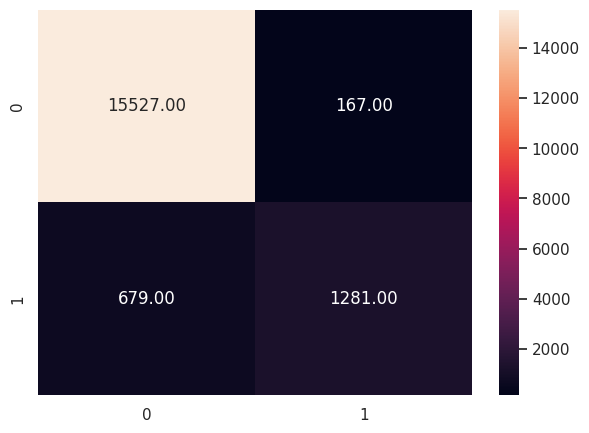

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f')

KNeighborsClassifier:

In [ ]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall', return_train_score=False, verbose=3)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....algorithm=auto, n_neighbors=3;, score=0.975 total time=   4.7s
[CV 2/5] END .....algorithm=auto, n_neighbors=3;, score=0.967 total time=   5.7s
[CV 3/5] END .....algorithm=auto, n_neighbors=3;, score=0.971 total time=   4.7s
[CV 4/5] END .....algorithm=auto, n_neighbors=3;, score=0.976 total time=   4.7s
[CV 5/5] END .....algorithm=auto, n_neighbors=3;, score=0.974 total time=   5.8s
[CV 1/5] END .....algorithm=auto, n_neighbors=4;, score=0.954 total time=   4.6s
[CV 2/5] END .....algorithm=auto, n_neighbors=4;, score=0.939 total time=   5.2s
[CV 3/5] END .....algorithm=auto, n_neighbors=4;, score=0.953 total time=   4.8s
[CV 4/5] END .....algorithm=auto, n_neighbors=4;, score=0.962 total time=   4.5s
[CV 5/5] END .....algorithm=auto, n_neighbors=4;, score=0.962 total time=   5.8s
[CV 1/5] END .....algorithm=auto, n_neighbors=5;, score=0.958 total time=   4.5s
[CV 2/5] END .....algorithm=auto, n_neighbors=5

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall', verbose=3)

In [ ]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [ ]:
KN_model = KNeighborsClassifier(n_neighbors=3)
KN_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = KN_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.9895221058011755

<Axes: >

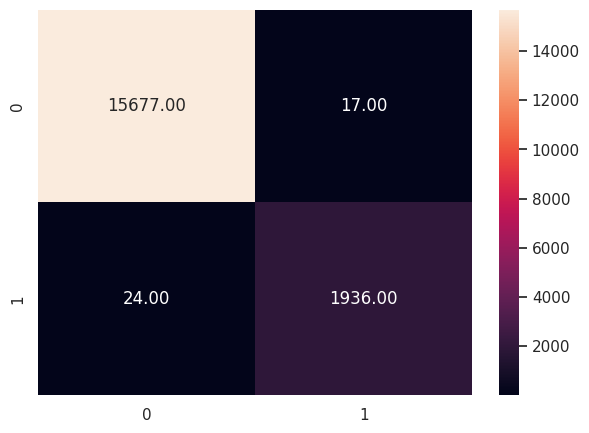

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f')

SVC:

In [ ]:
tuned_parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), tuned_parameters, refit = True, verbose = 3)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.891 total time= 4.4min


In [ ]:
SVC_model = SVC(C=1, gamma=0.1, kernel='rbf')
SVC_model.fit(X_train, y_train)

In [ ]:
y_pred = SVC_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f')

Получаем 3 модели: LogisticRegression с точностью 0.75, KNeighborsClassifier с 0.989 и SVC с 0.975

In [ ]:
with open('LR_model.pkl','wb') as f:
    pickle.dump(LR_model, f)

In [ ]:
with open('SVC_model.pkl','wb') as f:
    pickle.dump(SVC_model, f)

In [ ]:
with open('KN_model.pkl','wb') as f:
    pickle.dump(KN_model, f)